#### Problem Statement

ABC is an online content sharing platform that enables users to create, upload and share the content in the form of videos. 
It includes videos from different genres like entertainment, education, sports, technology and so on. The maximum duration 
of video is 10 minutes.

Users can like, comment and share the videos on the platform. 

Based on the user’s interaction with the videos, engagement score is assigned to the video with respect to each user. 
Engagement score defines how engaging the content of the video is. 

Understanding the engagement score of the video improves the user’s interaction with the platform. It defines the type 
of content that is appealing to the user and engages the larger audience.

### 1. Importing Libraries

In [20]:
import pandas as pd
import numpy as np

# visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn  import metrics

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


### 2. Data Inspection

In [21]:
org_train = pd.read_csv('train_0OECtn8.csv')
org_test = pd.read_csv('test_1zqHu22.csv')

train = org_train.drop('row_id', axis = 1)
test = org_test.drop('row_id', axis = 1)

train.shape, test.shape

((89197, 9), (11121, 8))

In [22]:
org_train['row_id'].nunique()

89197

In [98]:
train['engagement_score'].min()

0.0

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89197 entries, 0 to 89196
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           89197 non-null  int64  
 1   category_id       89197 non-null  int64  
 2   video_id          89197 non-null  int64  
 3   age               89197 non-null  int64  
 4   gender            89197 non-null  object 
 5   profession        89197 non-null  object 
 6   followers         89197 non-null  int64  
 7   views             89197 non-null  int64  
 8   engagement_score  89197 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 6.1+ MB


* __there are no missing values in train data.__

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11121 entries, 0 to 11120
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      11121 non-null  int64 
 1   category_id  11121 non-null  int64 
 2   video_id     11121 non-null  int64 
 3   age          11121 non-null  int64 
 4   gender       11121 non-null  object
 5   profession   11121 non-null  object
 6   followers    11121 non-null  int64 
 7   views        11121 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 695.2+ KB


* __there are no missing values in test data.__

In [25]:
#numerical features
print("Numerical Features count in Train Set:",train.select_dtypes(exclude = 'object').shape[1])

#categorical features
print("Categorical Features count in Train Set:",train.select_dtypes('object').shape[1])

Numerical Features count in Train Set: 7
Categorical Features count in Train Set: 2


In [26]:
#numerical features
print("Numerical Features count in Train Set:",test.select_dtypes(exclude = 'object').shape[1])

#categorical features
print("Categorical Features count in Train Set:",test.select_dtypes('object').shape[1])

Numerical Features count in Train Set: 6
Categorical Features count in Train Set: 2


### 3. Explanatory Data Analysis

In [27]:
print('Categorical Features:', train.select_dtypes('object').columns.to_list())
print('*' * 100)
print('Categorical Features:', train.select_dtypes(exclude = 'object').columns.to_list())

Categorical Features: ['gender', 'profession']
****************************************************************************************************
Categorical Features: ['user_id', 'category_id', 'video_id', 'age', 'followers', 'views', 'engagement_score']


In [28]:
train.head()

,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,19990,37,128,24,Male,Student,180,1000,4.33
1,5304,32,132,14,Female,Student,330,714,1.79
2,1840,12,24,19,Male,Student,180,138,4.35
3,12597,23,112,19,Male,Student,220,613,3.77
4,13626,23,112,27,Male,Working Professional,220,613,3.13


<AxesSubplot:xlabel='gender', ylabel='count'>

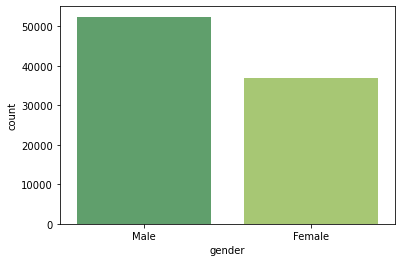

In [29]:
sns.countplot('gender', data=train, palette='summer')

<AxesSubplot:xlabel='profession', ylabel='count'>

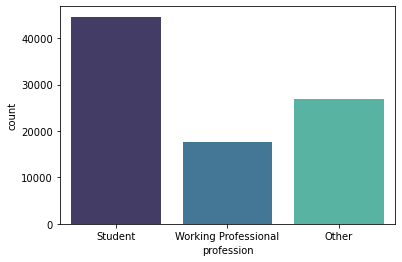

In [30]:
sns.countplot('profession', data=train, palette='mako')

<AxesSubplot:xlabel='category_id', ylabel='count'>

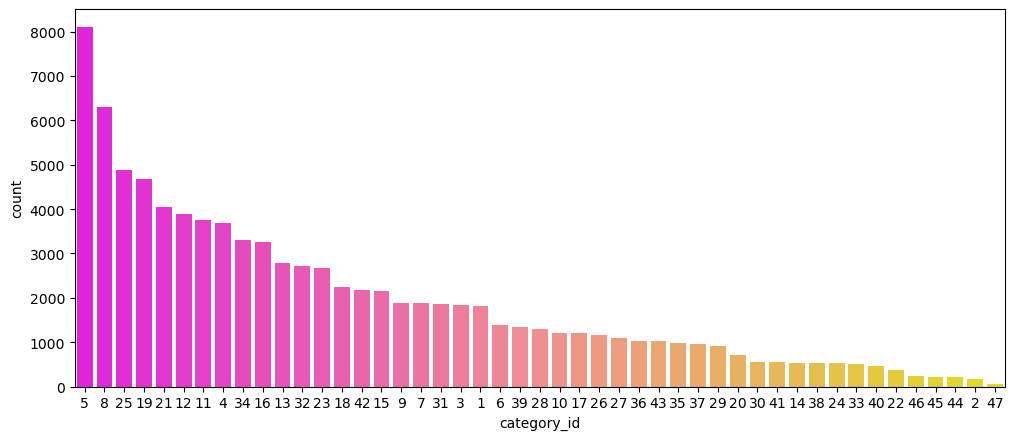

In [31]:
plt.figure(figsize=(12,5),dpi = 100)
sns.countplot('category_id', data = train, order = train['category_id'].value_counts().index , palette='spring')

category_id 5 has the most records

<AxesSubplot:xlabel='video_id', ylabel='count'>

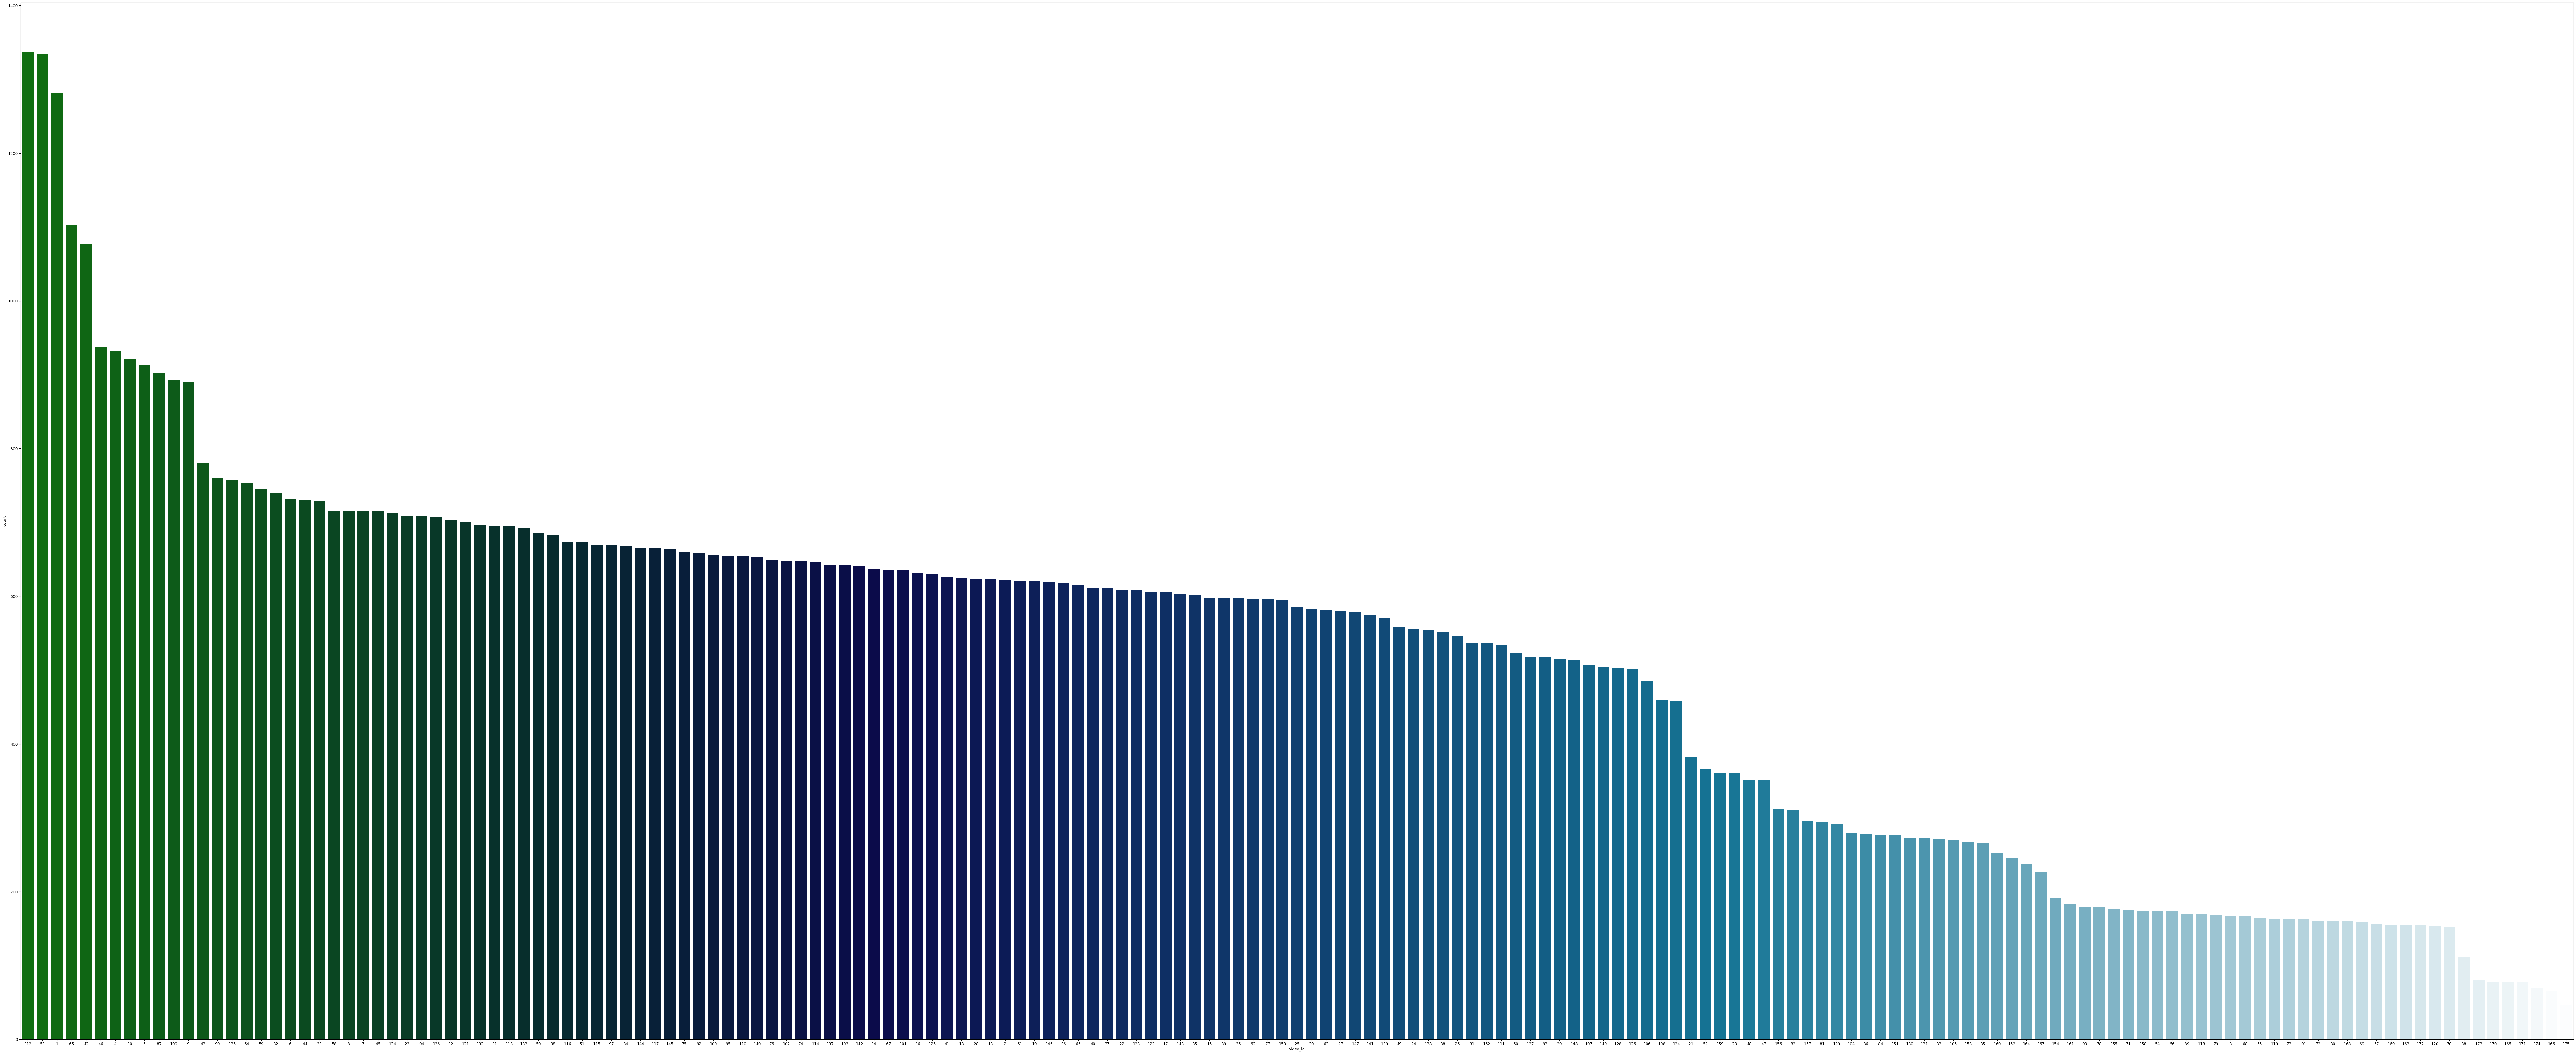

In [32]:
plt.figure(figsize=(120,50),dpi = 100)
sns.countplot('video_id', data = train, order = train['video_id'].value_counts().index , palette='ocean')

video_id 112 has the most records in tha dataset

<AxesSubplot:xlabel='age'>

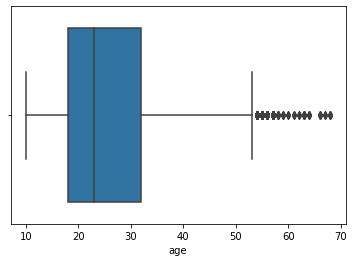

In [33]:
sns.boxplot('age', data = train)

* visible outliers in age feature

<AxesSubplot:xlabel='followers'>

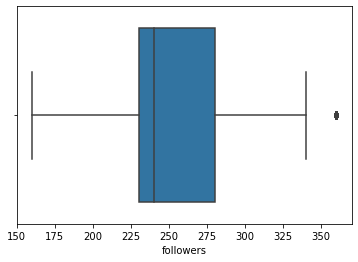

In [34]:
sns.boxplot('followers', data = train)

* minor outliers in followers feature

<AxesSubplot:xlabel='views'>

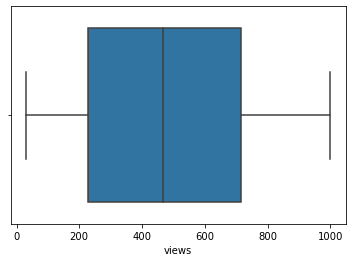

In [35]:
sns.boxplot('views', data = train)

# ********************************************************************************************

In [36]:
train[['user_id', 'category_id', 'video_id', 'age']]  = train[['user_id', 'category_id', 'video_id', 'age']].astype('int')
train.head()

,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,19990,37,128,24,Male,Student,180,1000,4.33
1,5304,32,132,14,Female,Student,330,714,1.79
2,1840,12,24,19,Male,Student,180,138,4.35
3,12597,23,112,19,Male,Student,220,613,3.77
4,13626,23,112,27,Male,Working Professional,220,613,3.13


I have taken below steps to create features by feature engineering:

1:
    * Filtering the data to interquantile range.
    * having dummies from `professional` feature
    * converting `gender` to lencode format

2:
    * having dummies from `professional` feature
    * converting `gender` to lencode format

3:
    * merging `gender` and `profession` features and using mean encode

4:
    * merging `gender` and `profession` features and getting their dummies as feature
    
    
5:
    * gettting dummies of `category_id` and `video_id`
    * using mean encode on `user_id`
    

# **** t0

In [37]:
train['age'].min(), train['age'].max()

(10, 68)

In [38]:
train['profession'].value_counts()

Student                 44638
Other                   26840
Working Professional    17719
Name: profession, dtype: int64

In [39]:
prof_encod = pd.get_dummies(train['profession'])
prof_encod.drop('Working Professional', axis = 1, inplace= True)
prof_encod.rename(columns = {'Student':'Profession_Student', 'Other':'Profession_Others'}, inplace=True)
prof_encod['Profession_Student'].value_counts(), prof_encod['Profession_Others'].value_counts() 

(1    44638
 0    44559
 Name: Profession_Student, dtype: int64,
 0    62357
 1    26840
 Name: Profession_Others, dtype: int64)

In [40]:
t0 = pd.concat([train, prof_encod], axis = 1)

In [41]:
t0.drop('profession', axis = 1, inplace = True)

In [42]:
t0['gender'] = t0['gender'].map({'Male': 1, 'Female' : 0})

In [43]:
q1 = t0.quantile(0.25)
q3 = t0.quantile(0.75)
IQR = q3 - q1
IQR

user_id               13874.00
category_id              18.00
video_id                 86.00
age                      14.00
gender                    1.00
followers                50.00
views                   485.00
engagement_score          1.25
Profession_Others         1.00
Profession_Student        1.00
dtype: float64

In [45]:
t0 = t0[~((t0 < (q1 - 1.5 * IQR)) |(t0 > (q3 + 1.5 * IQR))).any(axis=1)]
t0.shape

(86370, 10)

In [47]:
t0.corr().to_csv('t0corr.csv')

In [48]:
ct0 = t0.drop(['Profession_Student'], axis = 1)

In [49]:
t0.head()

,user_id,category_id,video_id,age,gender,followers,views,engagement_score,Profession_Others,Profession_Student
0,19990,37,128,24,1,180,1000,4.33,0,1
1,5304,32,132,14,0,330,714,1.79,0,1
2,1840,12,24,19,1,180,138,4.35,0,1
3,12597,23,112,19,1,220,613,3.77,0,1
4,13626,23,112,27,1,220,613,3.13,0,0


# **** t0


* __having dummies from `professional` feature__
* __converting `gender` to lencode format__
* __getting the data from interquantile range__

# **** t1

In [50]:
t0_1 = pd.concat([train, prof_encod], axis = 1)

In [51]:
t0_1.drop('profession', axis = 1, inplace = True)

In [52]:
t0_1['gender'] = t0_1['gender'].map({'Male':1, 'Female': 0})

In [53]:
t0_1.dtypes


user_id                 int32
category_id             int32
video_id                int32
age                     int32
gender                  int64
followers               int64
views                   int64
engagement_score      float64
Profession_Others       uint8
Profession_Student      uint8
dtype: object

In [54]:
t0_1.head()

,user_id,category_id,video_id,age,gender,followers,views,engagement_score,Profession_Others,Profession_Student
0,19990,37,128,24,1,180,1000,4.33,0,1
1,5304,32,132,14,0,330,714,1.79,0,1
2,1840,12,24,19,1,180,138,4.35,0,1
3,12597,23,112,19,1,220,613,3.77,0,1
4,13626,23,112,27,1,220,613,3.13,0,0


In [55]:
for col in t0_1.columns:
    percentiles = t0_1[col].quantile([0.01, 0.99]).values
    t0_1[col] = np.clip(t0_1[col], percentiles[0], percentiles[1])

In [58]:
t0_1['views'] = t0_1['views'].astype('int')

t0_1.head()

,user_id,category_id,video_id,age,gender,followers,views,engagement_score,Profession_Others,Profession_Student
0,19990.0,37.0,128.0,24.0,1,180,1000,4.33,0,1
1,5304.0,32.0,132.0,14.0,0,330,714,1.79,0,1
2,1840.0,12.0,24.0,19.0,1,180,138,4.35,0,1
3,12597.0,23.0,112.0,19.0,1,220,613,3.77,0,1
4,13626.0,23.0,112.0,27.0,1,220,613,3.13,0,0


# **** t1


* __having dummies from `professional` feature__
* __converting `gender` to lencode format__

I have taken below steps to create features by feature engineering:

1:
    * Filtering the data to interquantile range.
    * creating dummies from `professional` feature
    * converting `gender` to lencode format

2:
    * having dummies from `professional` feature
    * converting `gender` to lencode format

3:
    * merging `gender` and `profession` features and using mean encode

4:
    * merging `gender` and `profession` features and getting their dummies as feature
    
    
5:
    * gettting dummies of `category_id` and `video_id`
    * using mean encode on `user_id`
    

# Model Starts

In [95]:
t = t0
    
X= t.drop(columns = ['engagement_score'], axis=1)
y= t['engagement_score']

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=21)
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((69096, 9), (17274, 9), (69096,), (17274,))

In [96]:
lr = LinearRegression()
rf = RandomForestRegressor()
xg = XGBRegressor()

algos = [lr, rf, xg]

names = ['Linear Regression', 'Random Forest Regressor', 'XGBRegressor']

rmse_list = []

for name in algos:
    model = name
    model.fit(X_train,y_train)
    yt_pred = model.predict(X_train)
    y_pred = model.predict(X_valid)
    rt2= metrics.r2_score(y_train,yt_pred)
    r2= metrics.r2_score(y_valid,y_pred)

    print(f'{model}: Training={round(rt2, 4)},  Testing={round(r2, 4)}')

LinearRegression(): Training=0.2706,  Testing=0.2768
RandomForestRegressor(): Training=0.9112,  Testing=0.3799
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None): Training=0.4557,  Testing=0.3749


In [77]:
xgb_final = XGBRegressor(n_estimators = 6000, learning_rate = 0.05)
xgb_final.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=6000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [81]:
yt_pred = xgb_final.predict(X)
# y_pred = xgb_final.predict(X_valid)
rt2= metrics.r2_score(y,yt_pred)
# r2= metrics.r2_score(y_valid,y_pred)

print(f'XGBoostRegressor: Training={round(rt2, 4)}')

XGBoostRegressor: Training=0.7168


# Taking same steps for test data as t1

In [82]:
test.head()

,user_id,category_id,video_id,age,gender,profession,followers,views
0,7986,12,42,14,Male,Student,180,138
1,11278,34,115,14,Male,Student,230,840
2,17245,8,110,44,Female,Working Professional,280,628
3,9851,16,137,18,Male,Student,270,462
4,16008,34,96,47,Female,Other,230,840


In [83]:
prof_encod_t = pd.get_dummies(test['profession'])
prof_encod_t.drop('Working Professional', axis = 1, inplace= True)
prof_encod_t.rename(columns = {'Student':'Profession_Student', 'Other':'Profession_Others'}, inplace=True)
prof_encod_t['Profession_Student'].value_counts(), prof_encod_t['Profession_Others'].value_counts() 

(1    5572
 0    5549
 Name: Profession_Student, dtype: int64,
 0    7755
 1    3366
 Name: Profession_Others, dtype: int64)

In [84]:
final_test = pd.concat([test, prof_encod_t], axis = 1)

In [85]:
final_test.drop('profession', axis = 1, inplace = True)

In [86]:
final_test['gender'] = final_test['gender'].map({'Male':1, 'Female': 0})

In [87]:
t0_1.head()

,user_id,category_id,video_id,age,gender,followers,views,engagement_score,Profession_Others,Profession_Student
0,19990.0,37.0,128.0,24.0,1,180,1000,4.33,0,1
1,5304.0,32.0,132.0,14.0,0,330,714,1.79,0,1
2,1840.0,12.0,24.0,19.0,1,180,138,4.35,0,1
3,12597.0,23.0,112.0,19.0,1,220,613,3.77,0,1
4,13626.0,23.0,112.0,27.0,1,220,613,3.13,0,0


In [88]:
final_test.head()

,user_id,category_id,video_id,age,gender,followers,views,Profession_Others,Profession_Student
0,7986,12,42,14,1,180,138,0,1
1,11278,34,115,14,1,230,840,0,1
2,17245,8,110,44,0,280,628,0,0
3,9851,16,137,18,1,270,462,0,1
4,16008,34,96,47,0,230,840,1,0


In [90]:
xg_final = pd.DataFrame()
xg_final['row_id'] = org_test['row_id']
xg_final['engagement_score'] = xgb_final.predict(final_test)
# xg_final['engagement_score'] = xg_final['engagement_score'].apply(lambda x: round(x, 2))

xg_final[['row_id', 'engagement_score']].to_csv('ScorePredSub.csv', index=False)